In [35]:
import tensorflow as tf
from keras.api.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout
from keras.api.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (_, _) = fashion_mnist.load_data()
x_train = x_train[:15000] / 255.0
x_train = np.expand_dims(x_train, axis=-1)

BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(15000).batch(BATCH_SIZE)


In [36]:
def build_generator():
    model = tf.keras.Sequential([
        Dense(256, use_bias=False, input_shape=(100,)),
        BatchNormalization(),
        LeakyReLU(),
        Dense(7*7*128, use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 128)),
        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        LeakyReLU(),
        Dropout(0.3),
        Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),
        Flatten(),
        Dense(1)
    ])
    return model

In [37]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [38]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

E0000 00:00:1736986368.961081   31126 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_21_1/dropout_19_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1/30 completed.
Epoch 2/30 completed.
Epoch 3/30 completed.
Epoch 4/30 completed.
Epoch 5/30 completed.
Epoch 6/30 completed.


2025-01-16 02:13:20.677022: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7/30 completed.
Epoch 8/30 completed.
Epoch 9/30 completed.
Epoch 10/30 completed.
Epoch 11/30 completed.
Epoch 12/30 completed.
Epoch 13/30 completed.
Epoch 14/30 completed.
Epoch 15/30 completed.
Epoch 16/30 completed.
Epoch 17/30 completed.
Epoch 18/30 completed.
Epoch 19/30 completed.
Epoch 20/30 completed.
Epoch 21/30 completed.
Epoch 22/30 completed.
Epoch 23/30 completed.
Epoch 24/30 completed.
Epoch 25/30 completed.
Epoch 26/30 completed.
Epoch 27/30 completed.
Epoch 28/30 completed.
Epoch 29/30 completed.
Epoch 30/30 completed.


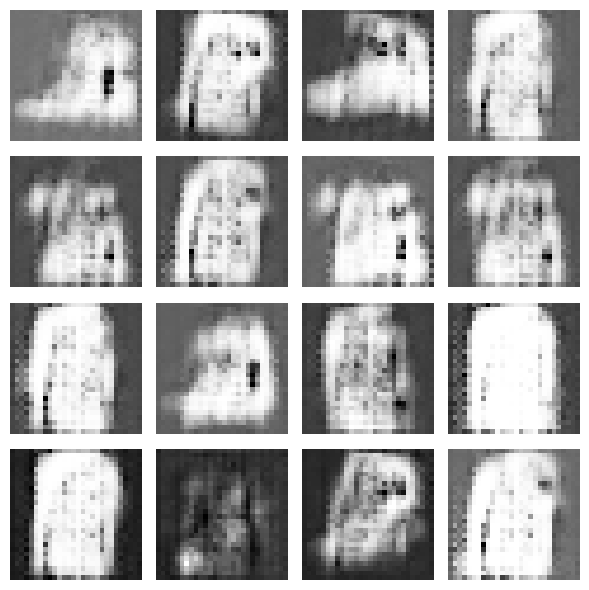

In [39]:
EPOCHS = 30
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        
        print(f"Epoch {epoch + 1}/{epochs} completed.")

        if epoch == epochs - 1:
            predictions = generator(seed, training=False)
            fig, axs = plt.subplots(4, 4, figsize=(6, 6))

            for i, ax in enumerate(axs.flat):
                ax.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
                ax.axis('off')

            plt.tight_layout()
            plt.show()

train(train_dataset, EPOCHS)